<a href="https://colab.research.google.com/github/macorony/NeuralNetwork/blob/main/train_model_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = ('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[classes[i] for i in [1,2,3]]

['automobile', 'bird', 'cat']

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 88393543.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

In [7]:
for i, data in enumerate(train_loader):
  print(train_loader)
  dummy_data = data
  break

In [8]:
dummy_data[0].shape

torch.Size([4, 3, 32, 32])

In [20]:
def loader_show(dataloader):
  images, labels = next(iter(train_loader))
  grid = torchvision.utils.make_grid(images)
  plt.imshow(grid.permute(1,2,0))
  print([classes[i] for i in labels])
  plt.show()

['ship', 'cat', 'frog', 'cat']


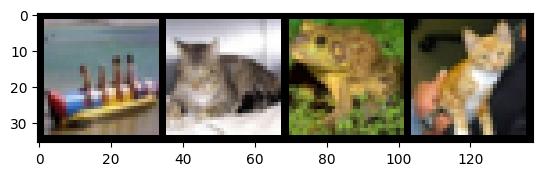

['frog', 'dog', 'bird', 'airplane']


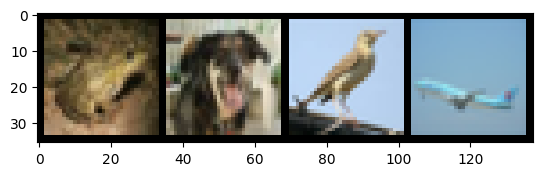

['cat', 'horse', 'horse', 'dog']


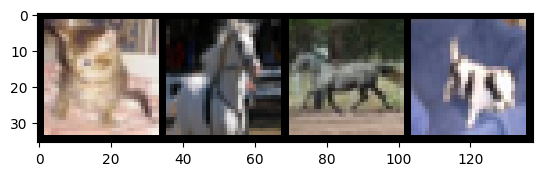

['automobile', 'truck', 'frog', 'ship']


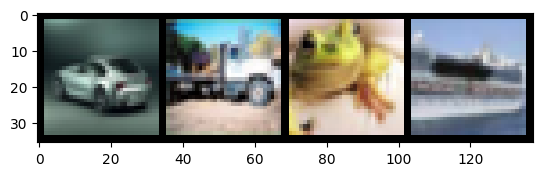

In [21]:
for _ in range(4):
  loader_show(train_loader)

## Model

In [11]:
class NNmodel(nn.Module):
  def __init__(self):
    super(NNmodel, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 10)

  def forward(self, input):
    x = self.pool(F.relu(self.conv1(input)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)
    return output

model = NNmodel()
print(model)

NNmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Loss function

In [12]:
loss_fun = nn.CrossEntropyLoss()

In [14]:
# a dummy test for loss function
images, labels = next(iter(train_loader))
dummy_label = torch.arange(0, 4)
dummy_output = model(images)
print(dummy_label.shape)
print(dummy_output.shape)
loss = loss_fun(dummy_output, dummy_label)
print(loss.item())

torch.Size([4])
torch.Size([4, 10])
2.2638540267944336


## Optimizer

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
model

NNmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

## Training

In [17]:
for epoch in range(1):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    # zero gradient for every batch
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fun(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f"[{epoch + 1}, {i + 1: 5d}] loss: {running_loss / 2000:.3f}")
      running_loss = 0.0

[1,  2000] loss: 2.236
[1,  4000] loss: 2.020
[1,  6000] loss: 1.867
[1,  8000] loss: 1.739
[1,  10000] loss: 1.661
[1,  12000] loss: 1.592


In [19]:
Path = '/content/drive/MyDrive/file_transmission/cifar10_net.pth'
torch.save(model.state_dict(), Path)

['frog', 'dog', 'dog', 'cat']


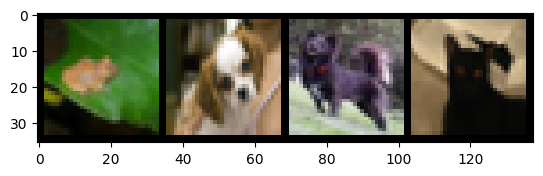

In [23]:
# a simple test
loader_show(test_loader)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [55]:
print(f'The accuracy of the model is {100 * correct/total}%')

The accuracy of the model is 44.13%


In [32]:
correct_pred = {classname:0 for classname in classes}
total_pred = {classname:0 for classname in classes}

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

In [28]:
for test in test_loader:
  images, labels = test
  print(images.shape)
  print(labels)
  break

torch.Size([4, 3, 32, 32])
tensor([0, 5, 5, 6])


In [59]:
unknown, predicted = torch.max(model(images).data, 1)
predicted

tensor([6, 7, 0, 1])

In [24]:
dummy_labels = torch.tensor([1,5,3,7])
print(dummy_labels.shape)
dummy_outputs = torch.rand(4,10)
print(dummy_outputs.shape)

torch.Size([4])
torch.Size([4, 10])


In [ ]:
dummy_output.shape

torch.Size([4, 100])

In [ ]:
dummy_output.shape

torch.Size([4, 100])

In [ ]:
images.shape

torch.Size([4, 3, 32, 32])

In [ ]:
output = model(images)

In [ ]:
output

tensor([[ 2.4645e-02, -2.5426e-02, -9.6567e-02, -2.6704e-02,  4.5618e-02,
          2.0543e-02,  6.3121e-03,  7.0688e-02,  7.9460e-02,  6.0939e-02,
         -6.7667e-02, -1.0765e-02,  4.1424e-02,  5.7659e-02, -4.5872e-02,
          4.9553e-02,  4.4185e-02, -3.6208e-02, -3.7393e-02, -6.3389e-02,
          1.8001e-02, -4.8261e-02,  1.2380e-02,  4.2904e-02, -3.7671e-02,
         -7.0899e-03, -4.8289e-02,  1.7584e-02, -6.5964e-02,  1.0825e-01,
          6.0549e-02, -2.0725e-02, -1.3701e-02, -3.4351e-02, -7.8076e-02,
          7.9972e-02, -7.2672e-03,  3.5116e-03, -5.8536e-02,  1.9806e-02,
         -1.3108e-02,  6.7720e-04, -5.7241e-02,  4.1875e-02, -1.3514e-02,
         -2.6041e-02, -4.3034e-02, -3.6570e-02,  6.8652e-03,  1.1566e-01,
         -8.5213e-02,  2.6491e-02,  5.4471e-02, -1.1101e-02, -3.4825e-02,
          1.6248e-02, -2.3828e-02,  1.6267e-02,  1.4352e-01,  4.8897e-02,
          3.8209e-02, -2.1391e-02, -3.6251e-02, -4.4255e-02, -9.6995e-02,
         -5.4342e-02, -5.3979e-02,  2.